In [1]:
%run "Common setup.ipynb"

In [2]:
from SALib.analyze.radial_ee import analyze as ee_analyze
from SALib.analyze.sobol_jansen import analyze as jansen_analyze

from SALib.plotting.bar import plot as barplot

In [3]:
# results produced with
# python launch.py --specific_inputs oat_mc_10_samples.csv --num_cores 48
# python launch.py --specific_inputs extremes_samples.csv --num_cores 2
# python launch.py --specific_inputs moat_10_samples.csv --num_cores 46

def collect_results(problem, oat_length, reps, np_res, numeric_vals):
    jansen_results_df = pd.DataFrame()
    ee_results_df = pd.DataFrame()
    rep_length = oat_length * reps
    _, cols = np_res.shape
    for col in range(cols):
        cn = col_names[col]
        res = np_res[:rep_length, col]
        si = jansen_analyze(problem, res, reps, seed=101)
        js_df = si.to_df()
        js_df.columns = ['{}_{}'.format(cn, suf) for suf in js_df.columns]
        jansen_results_df = pd.concat([jansen_results_df, js_df], axis=1)
        si = ee_analyze(problem, numeric_vals[:rep_length],
                        res, reps, seed=101)
        ee_df = si.to_df()
        ee_df.columns = ['{}_{}'.format(cn, suf) for suf in ee_df.columns]
        ee_results_df = pd.concat([ee_results_df, ee_df], axis=1)
    return jansen_results_df, ee_results_df
# End collect_results()

def plot_results(jansen_results_df, ee_results_df, target_metric):
    idx = [True if 'irrigation' in r.lower() else False for r in jansen_results_df.index]
    tgt_idx = [c for c in ee_results_df.columns if target_metric.lower() in c.lower()]
    ax = ee_results_df.loc[idx, tgt_idx].plot(kind='bar', figsize=(10,6))
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# End plot_results()

In [4]:
template_df = pd.read_csv(f'{DATA_DIR}example_sample.csv', index_col=0)
is_perturbed = (template_df != template_df.iloc[0]).any()
perturbed_cols = template_df.loc[:, is_perturbed].columns
target_num_vars = CIM_SPEC['num_vars']
oat_length = target_num_vars + 1

target_metric = "Recreation Index"  # "SW Allocation Index"  # "Ecology Index"

In [5]:
numeric_samples = pd.read_csv(f'{DATA_DIR}extreme_numeric_samples.csv', index_col=0)
numeric_samples = numeric_samples[perturbed_cols]
numeric_vals = numeric_samples.values
extreme_results = pd.read_csv(f'{DATA_DIR}no_irrigation_extreme_results.csv', index_col=0)
np_res = extreme_results.values
col_names = extreme_results.columns

In [6]:
### Extremity testing ###

# Extreme values without interactions
model_results = {}

for i in range(len(col_names)):
    x_diff = (numeric_vals[0, :] - numeric_vals[1, :])
    y_diff = (np_res[0, i] - np_res[1, i])
    model_results[col_names[i]] = abs(y_diff / x_diff)
# End for

no_ext_results = pd.DataFrame(model_results, index=perturbed_cols).T
no_ext_results.columns = [c.replace('Farm___Irrigations___', '') for c in no_ext_results.columns]
tgt_cols = [c for c in no_ext_results.columns if 'gravity___irrigation_efficiency' in c.lower()]


### Extremes with interactions ###
extreme_results = pd.read_csv(f'{DATA_DIR}with_irrigation_extreme_results.csv', index_col=0)
np_res = extreme_results.values
col_names = extreme_results.columns
model_results = {}

for i in range(len(col_names)):
    x_diff = (numeric_vals[0, :] - numeric_vals[1, :])
    y_diff = (np_res[0, i] - np_res[1, i])
    model_results[col_names[i]] = abs(y_diff / x_diff)
# End for

with_ext_results = pd.DataFrame(model_results, index=perturbed_cols).T
tgt_idx = [c for c in with_ext_results.index if target_metric.lower() in c.lower()]
with_ext_results.columns = [c.replace('Farm___Irrigations___', '') for c in with_ext_results.columns]
tgt_cols = [c for c in with_ext_results.columns if 'gravity___irrigation_efficiency' in c.lower()]

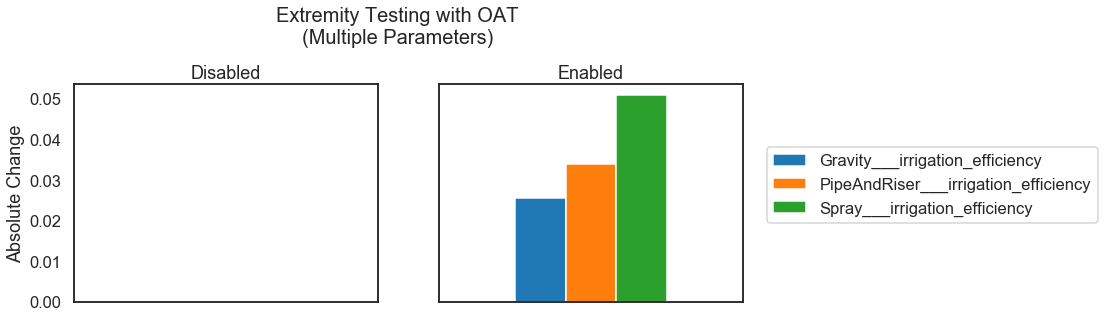

In [7]:
selected_cols = [c for c in with_ext_results.columns 
                 if 'irrigation_eff' in c.lower()]

selected_no_ext = no_ext_results.loc[:, selected_cols]
selected_no_ext.columns = selected_no_ext.columns.str.replace('Farm___Crops___variables___', '')

selected_with_ext = with_ext_results.loc[:, selected_cols]
selected_with_ext.columns = selected_with_ext.columns.str.replace('Farm___Crops___variables___', '')


fig, axes = plt.subplots(1,2, figsize=(12,4), sharey=True, sharex=True)

selected_no_ext.loc[tgt_idx, :].plot(kind='bar', legend=None, 
                                           title='Disabled',
                                           ax=axes[0], 
                                           rot=0)

axes[0].set_ylabel('Absolute Change')

x_axis = axes[0].axes.get_xaxis()
x_axis.set_visible(False)


selected_with_ext.loc[tgt_idx, :].plot(kind='bar', 
                                             legend=None,
                                             title='Enabled',
                                             rot=0,
                                             ax=axes[1]).legend(
                                                bbox_to_anchor=(1.05, 0.75)
                                             )

x_axis = axes[1].axes.get_xaxis()
x_axis.set_visible(False)

fig.suptitle("Extremity Testing with OAT\n(Multiple Parameters)", x=0.5, y=1.15, fontsize=20);
fig.savefig(f'{FIG_DIR}extremity_testing_multi_param_results.png', dpi=300, bbox_inches='tight')